# Churn Prediction

## Importing Packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import joblib
from pathlib import Path

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Data Pre-processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost

# Model Selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

# For Deep Learning
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

2.7.0


### Helper Functions

In [2]:
# Reset global arrays
def reset():
    global y_true_arr, y_pred_arr
    y_true_arr, y_pred_arr = [], []

In [3]:
# Store each K split true class and prediction values
y_true_arr = []
y_pred_arr = []

def classification_report_with_accuracy(y_true, y_pred):
    y_true_arr.extend(y_true)
    y_pred_arr.extend(y_pred)
    return accuracy_score(y_true, y_pred)

In [4]:
# This function Draw each Cross Validation Fold epochs 
def draw_graph(arr, header):
    plt.title(f"{header}")
    plt.xlabel("epoch")
    plt.ylabel(f"{header}")
    for k in range(len(arr)):
        plt.plot(arr[k], label=f'K = {k}')
    plt.legend()
    plt.show()

## Read the CSV data file

In [5]:
#import data
df = pd.read_csv(Path('./Data/churn_data.csv'))
df.head()

,city,zip,lat,long,gender,senior_citizen,partner,dependents,tenure,phone_service,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1


In [6]:
# Data shape
df.shape

(7032, 24)

In [7]:
# Target Class Distribution
df["churn"].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

## Data Pre-Processing

In [8]:
# Checking data types
df.dtypes

city                  object
zip                    int64
lat                  float64
long                 float64
gender                object
senior_citizen        object
partner               object
dependents            object
tenure                 int64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
churn                  int64
dtype: object

In [9]:
# Value counts for each column
for i in range(df.shape[1]):
    print(df.columns[i], ' : ', df.iloc[:, i].nunique())

city  :  1129
zip  :  1652
lat  :  1652
long  :  1651
gender  :  2
senior_citizen  :  2
partner  :  2
dependents  :  2
tenure  :  72
phone_service  :  2
multiple_lines  :  3
internet_service  :  3
online_security  :  3
online_backup  :  3
device_protection  :  3
tech_support  :  3
streaming_tv  :  3
streaming_movies  :  3
contract  :  3
paperless_billing  :  2
payment_method  :  4
monthly_charges  :  1584
total_charges  :  6530
churn  :  2


In [10]:
# Statistical Summary of the df
df.describe()

,zip,lat,long,tenure,monthly_charges,total_charges,churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,93523.032565,36.283307,-119.799215,32.421786,64.798208,2283.300441,0.265785
std,1865.515958,2.456118,2.157588,24.545260,30.085974,2266.771362,0.441782
min,90001.000000,32.555828,-124.301372,1.000000,18.250000,18.800000,0.000000
25%,92102.000000,34.030915,-121.815412,9.000000,35.587500,401.450000,0.000000
50%,93552.500000,36.391777,-119.735410,29.000000,70.350000,1397.475000,0.000000
75%,95354.000000,38.227285,-118.043237,55.000000,89.862500,3794.737500,1.000000
max,96161.000000,41.962127,-114.192901,72.000000,118.750000,8684.800000,1.000000


### Data Splitting

In [11]:
# Features and Target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

### Feature Encoding

In [12]:
# Feature Separation
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = list(set(X.columns.tolist()) - set(categorical_features))

In [13]:
# Apply Ordinal encoder for categorical data
le = OrdinalEncoder()
le.fit(X[categorical_features])
X[categorical_features] = le.transform(X[categorical_features])

### Feature Scaling

In [14]:
# Standardize monthly_charges and monthly_charges
std_scaler = StandardScaler()
X[categorical_features+numerical_features] = std_scaler.fit_transform(
    X[categorical_features+numerical_features])

## Model Training and Evaluation

Cross Validation method is used here to prevent model overfitting

### Pipeline

In [15]:
# Prediction function using KFold Cross Validation
# And printing the results

# K = 10
cv = KFold(n_splits=10, shuffle=True, random_state=1)

def prediction_result(clf, X, y):
    global y_true_arr, y_pred_arr
        
    # Steps
    steps = [('model', clf)] # No Sampling
    # steps = [('up-sampling', SMOTE()), ('model', clf)] # Apply SNMOTE
    # steps = [('up-sampling', RandomOverSampler()), ('model', clf)] # Apply Upsampling
    # steps = [('Under-sampling', RandomUnderSampler()), ('model', clf)] # Apply Downsampling
    # steps = [('o', RandomOverSampler(sampling_strategy=0.5)), ('u', RandomUnderSampler(sampling_strategy=0.5)), ('m', clf)] # Apply Upsampling and Downsampling
    
    # Apply steps to pipeline
    pipeline = Pipeline(steps=steps)

    # Cross Validation Scores
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=make_scorer(classification_report_with_accuracy))
    
    # Accuracy Score
    print(f"Accuracy: {scores.mean()}\n")
    
    # Classification Report
    print(classification_report(y_true_arr, y_pred_arr))

    # Reset the Global arrays
    reset()

### Logistic Regression

In [16]:
lr_clf = LogisticRegression(penalty='l2', C=1, random_state=1)
prediction_result(lr_clf, X, y)

Accuracy: 0.8098694313332471

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5163
           1       0.66      0.58      0.62      1869

    accuracy                           0.81      7032
   macro avg       0.76      0.74      0.75      7032
weighted avg       0.80      0.81      0.81      7032



### Support Vector Machine

In [17]:
# SVM classifier with RBF kernel
svm_clf = SVC(kernel='rbf', random_state=1)
prediction_result(svm_clf, X, y)

Accuracy: 0.8054611728953833

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      5163
           1       0.68      0.52      0.58      1869

    accuracy                           0.81      7032
   macro avg       0.76      0.71      0.73      7032
weighted avg       0.80      0.81      0.80      7032



### Decision Tree

In [18]:
dt_clf = DecisionTreeClassifier(max_depth=4, min_samples_split=2, random_state=1)
prediction_result(dt_clf, X, y)

Accuracy: 0.7790098037630931

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      5163
           1       0.64      0.39      0.48      1869

    accuracy                           0.78      7032
   macro avg       0.72      0.65      0.67      7032
weighted avg       0.76      0.78      0.76      7032



### Random Forest

In [19]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=1)
prediction_result(rf_clf, X, y)

Accuracy: 0.8029015259278417

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      5163
           1       0.67      0.51      0.58      1869

    accuracy                           0.80      7032
   macro avg       0.75      0.71      0.73      7032
weighted avg       0.79      0.80      0.79      7032



### XGBoost Classifier

In [20]:
xgb_clf = XGBClassifier(n_estimators=80, max_depth=1, eval_metric='mlogloss', random_state=1)
prediction_result(xgb_clf, X, y)

Accuracy: 0.8110076134747187

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      5163
           1       0.67      0.56      0.61      1869

    accuracy                           0.81      7032
   macro avg       0.76      0.73      0.74      7032
weighted avg       0.80      0.81      0.81      7032



### Feature Importance

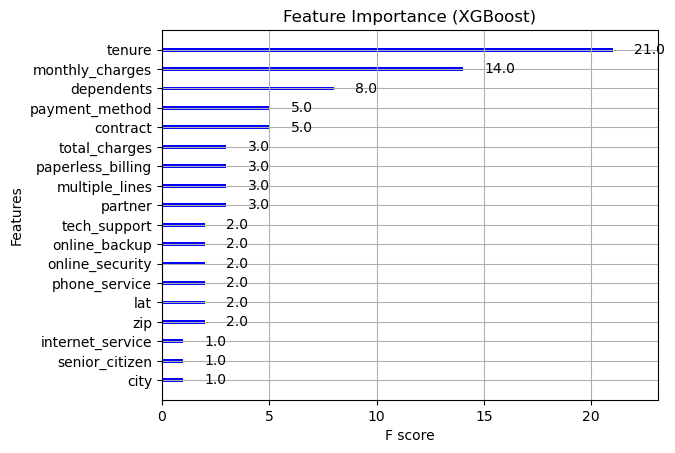

In [21]:
xgb_clf.fit(X,y)
xgboost.plot_importance(xgb_clf, title="Feature Importance (XGBoost)", color='Blue')
plt.show();

### CatBoost Classifier

In [22]:
cb_clf = CatBoostClassifier(random_state=1, verbose=False)
prediction_result(cb_clf, X, y)

Accuracy: 0.8023317276606748

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      5163
           1       0.65      0.54      0.59      1869

    accuracy                           0.80      7032
   macro avg       0.75      0.72      0.73      7032
weighted avg       0.79      0.80      0.80      7032



### Deep Learning Model

In [23]:
# Model Training
_X = X.to_numpy()
_y = y.to_numpy()
accuracy = []
val_accuracy = []
loss = []
val_loss = []
counter = 0
times = 1 # cross validation folds (set it 10 for all the folds)

for train_index, test_index in cv.split(X):
    if counter < times:
        print(f"\nCross Validation Training K={counter}\n")
        # Train Test split based on K fold Cross Validation split
        X_train, X_test = _X[train_index], _X[test_index]
        y_train, y_test = _y[train_index], _y[test_index]

        # Define the model
        model = keras.Sequential([
            #keras.layers.Dense(10, activation='relu'),
            #keras.layers.Dense(15, activation='relu'),
            #keras.layers.Dense(21, activation='relu'),
            keras.layers.Dense(16, input_shape=(X.shape[1],), activation='relu'),
            keras.layers.Dropout(0.4),
            #keras.layers.Dense(46, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])

        # Compile
        model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

        # Fit the training data
        # history = model.fit(X_train, y_train, batch_size=4, epochs=100, verbose=2)
        # history = model.fit(X_train, y_train, batch_size=8, epochs=100, verbose=2)
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=100, verbose=2)
        # history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=2)
        # history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=2)
        # history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=2)

        # Model prediction for test data
        y_pred = np.rint(model.predict(X_test))

        # storing in lists
        y_pred_arr.extend(y_pred)
        y_true_arr.extend(y_test)
        
        # Accuracy
        accuracy.append(history.history['accuracy'])
        val_accuracy.append(history.history['val_accuracy'])
        
        # Loss
        loss.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])

        # Increase counter
        counter += 1


Cross Validation Training K=0

Epoch 1/100
396/396 - 1s - loss: 0.6054 - accuracy: 0.6730 - val_loss: 0.4428 - val_accuracy: 0.7940 - 848ms/epoch - 2ms/step
Epoch 2/100
396/396 - 0s - loss: 0.4791 - accuracy: 0.7611 - val_loss: 0.4239 - val_accuracy: 0.7855 - 229ms/epoch - 578us/step
Epoch 3/100
396/396 - 0s - loss: 0.4467 - accuracy: 0.7900 - val_loss: 0.4185 - val_accuracy: 0.7955 - 220ms/epoch - 555us/step
Epoch 4/100
396/396 - 0s - loss: 0.4364 - accuracy: 0.7876 - val_loss: 0.4151 - val_accuracy: 0.7912 - 239ms/epoch - 603us/step
Epoch 5/100
396/396 - 0s - loss: 0.4338 - accuracy: 0.7897 - val_loss: 0.4114 - val_accuracy: 0.7955 - 224ms/epoch - 565us/step
Epoch 6/100
396/396 - 0s - loss: 0.4298 - accuracy: 0.7971 - val_loss: 0.4104 - val_accuracy: 0.7955 - 227ms/epoch - 573us/step
Epoch 7/100
396/396 - 0s - loss: 0.4220 - accuracy: 0.8020 - val_loss: 0.4100 - val_accuracy: 0.7969 - 225ms/epoch - 569us/step
Epoch 8/100
396/396 - 0s - loss: 0.4200 - accuracy: 0.8010 - val_loss: 0.4

### Model Evaluation

In [24]:
# Accuracy
print(f"Training Accuracy: {sum([sum(accuracy[k]) / len(accuracy[k]) for k in range(len(accuracy))]) / len(accuracy)}")
print(f"Validation Accuracy: {sum([sum(val_accuracy[k]) / len(val_accuracy[k]) for k in range(len(val_accuracy))]) / len(val_accuracy)}\n")

# classification Report
print(classification_report(y_true_arr, y_pred_arr))

Training Accuracy: 0.8058407044410706
Validation Accuracy: 0.8023437494039536

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       534
           1       0.62      0.50      0.55       170

    accuracy                           0.80       704
   macro avg       0.73      0.70      0.71       704
weighted avg       0.79      0.80      0.80       704



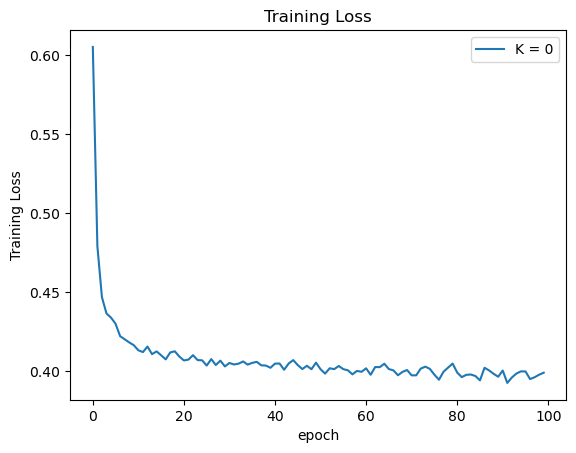

In [25]:
draw_graph(loss, "Training Loss")

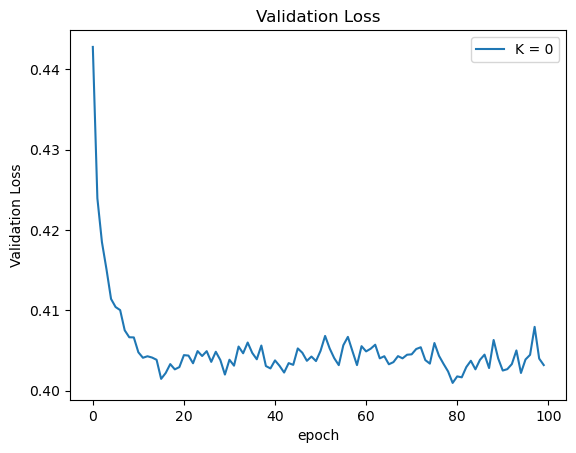

In [26]:
draw_graph(val_loss, "Validation Loss")

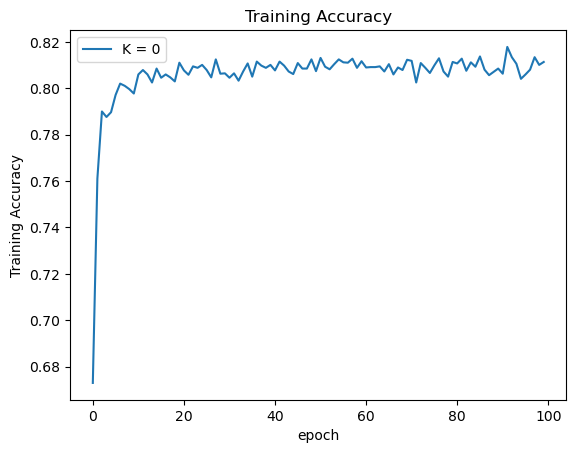

In [27]:
draw_graph(accuracy, "Training Accuracy")

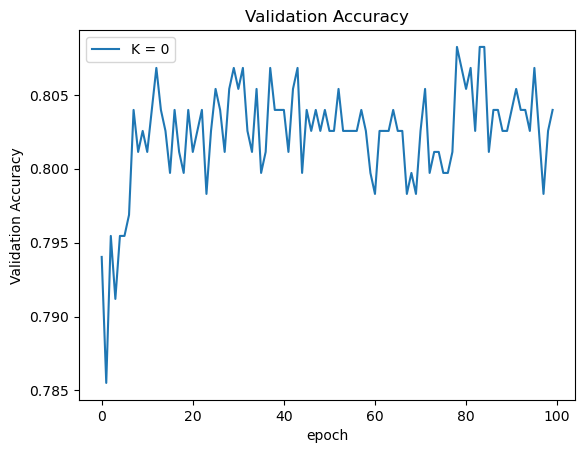

In [28]:
draw_graph(val_accuracy, "Validation Accuracy")

In [29]:
reset() # Reset the Global arrays

## Save Model

In [30]:
# Saving the model elements
joblib.dump(le, Path('./Model/label_encoder.joblib'))
joblib.dump(std_scaler, Path('./Model/std_scaler.joblib'))
joblib.dump(xgb_clf, Path('./Model/xgb_clf.joblib'))
joblib.dump(categorical_features, Path('./Model/categorical_features.joblib'))
joblib.dump(numerical_features, Path('./Model/numerical_features.joblib'))

['Model\\numerical_features.joblib']